In [1]:
import numpy as np
import gymnasium as gym
import time
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Study how to use the environment

In [2]:
# Initialize the environment and reset the current one. Set is_slippery=False in the initializer.
g = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="human")
g.reset()  # Resets the environment to an initial state, required before calling step. Returns the first agent observation for an episode and information, i.e. metrics, debug info.
g.render()  # Renders the environments to help visualise what the agent see, examples modes are “human”, “rgb_array”, “ansi” for text.

# Show the size of the action space and the number of possible states.
print(g.action_space)  # action space
print(g.observation_space)  # number of possible states
current_state = 0

Discrete(4)
Discrete(16)


In [3]:
# desc=["SFFF", "FHFH", "FFFH", "HFFG"]
# g.reset()
# g.render()
a = g.action_space.sample()  # 0:left 1:down 2:right 3:up

# format of returnValue is (observation,reward, terminated, truncated, info)
# observation (object)  - observed state
# reward (float)        - reward that is the result of taking the action
# terminated (bool)     - is it a terminal state
# truncated (bool)      - it is not important in our case
# info (dictionary)     - in our case transition probability
(next_state, reward, is_terminated, truncated, prob) = g.step(a)  # one step towards the ditection

print('p(s\'=%d|s=%d,a=%d) = %.1f' % (next_state, current_state, a, prob['prob']))
current_state = next_state

p(s'=0|s=0,a=3) = 1.0


In [4]:
# (transition_probability, next_state, reward, is_terminal_state) = g.P[current_state][a]

# 1.1. Implement Policy_Iteration

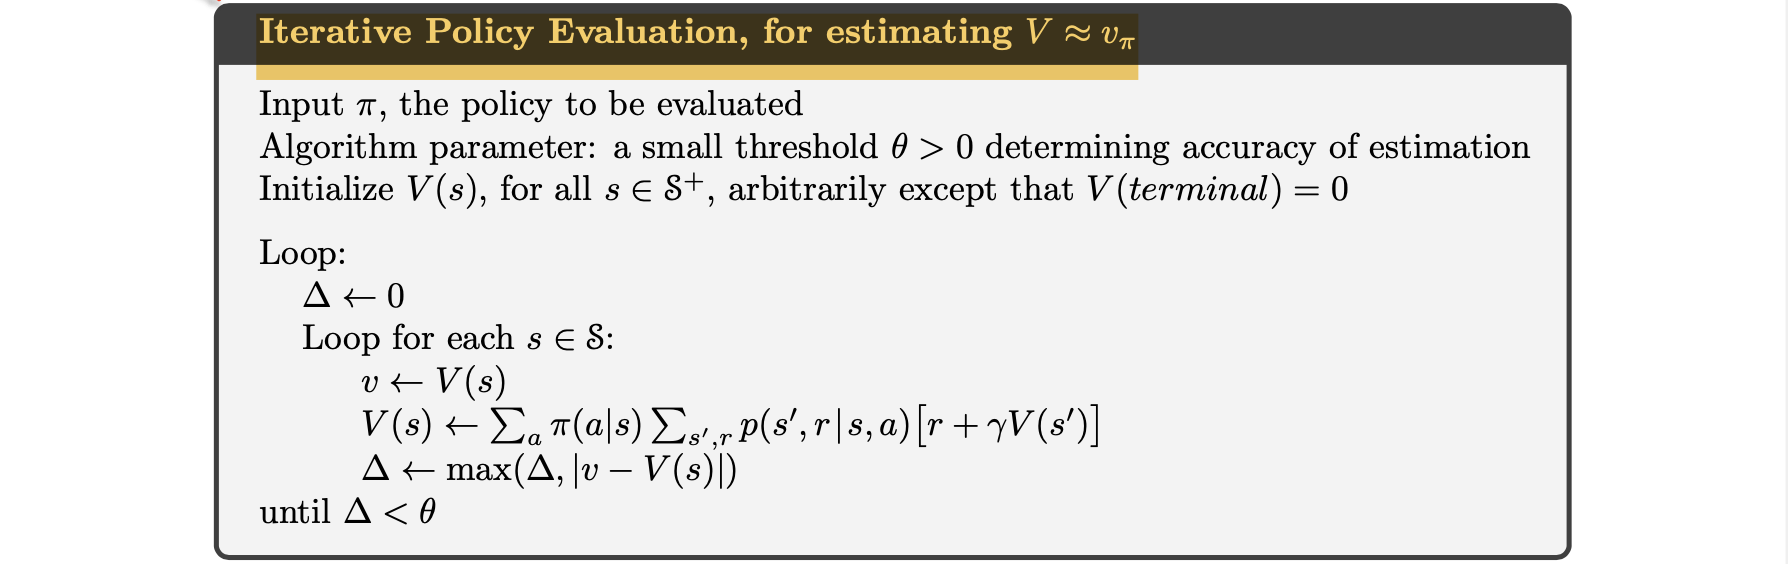

iter=0, continue
iter=1, continue
iter=2, continue
iter=3, continue
iter=4, continue
iter=5, continue
iter=6, continue
iter=7, continue
iter=8, continue
iter=9, continue
iter=10, continue
iter=11, continue
iter=12, converge at i=12, delta=0.000931



<AxesSubplot:>

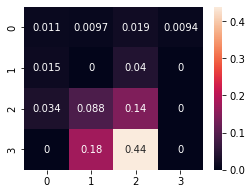

In [5]:
theta = 0.001  # error threshold
gamma = 1  # discord factor
S = np.zeros(16)  # save the state values in a matrix
g.reset()

def get_accum(current_state):
    action_space = g.P[current_state]  # scan for all the actions
    vs2 = 0
    for j, (action, x) in enumerate(action_space.items()):  # accumulation(p(a|s) * p(s',r|s,a) * [r+gV(s')])
        p = 1 / len(action_space)  # P(a|s)
        (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
        vs2 += p * 1 * (reward + gamma * S[next_state])  # P(a|s) * p(s',r|s,a) * [r+gV(s')]
        # print('p(s\'=%d|s=%d,a=%d) = %.1f, vs2=%.2f' % (next_state, current_state, action, prob['prob'], vs2))
    return vs2

# implementation of Iterative Policy Evaluation, for estimating V = v(pie)
def policy_iter():
    max_iter = 100  # prevent from a dead loop
    for i in range(max_iter):  # ---------------------------------------   Loop:
        print('iter=%d, ' % i, end='')
        delta = 0  # current error -------------------------------------      delta <- 0
        for current_state in range(g.observation_space.n - 1):  # ------      loop for each s belongs to S
            vs1 = S[current_state]  #  ---------------------------------         v <- V(s)
            vs2 = get_accum(current_state)  # --------------------------         V(s) <- sigma(p(a|s) * p(s',r|s,a) * [r+gV(s')])
            delta = max(np.fabs(vs1 - vs2), delta)  #  -----------------      delta <- max(delta, abs(vs1-vs2))
            S[current_state] = vs2  # update state value
        if(delta < theta):  # ------------------------------------------   until delta < theta
            print('converge at i=%d, delta=%f\n' % (i, delta))
            break 
        else:
            print('continue')
    pass

policy_iter()
arr = S.reshape(-1, 4)
df = pd.DataFrame(arr)  # turn 2-d array to dataframe
fig, ax = plt.subplots(figsize=(4, 3))  # figure size
sns.heatmap(df, annot=True)  # display both color and value

# 1.2. Drive Policy_Iteration with Policy_Improvement

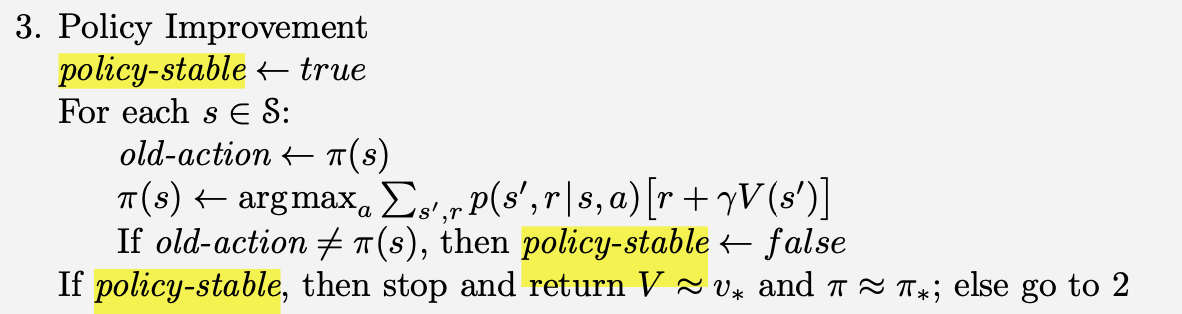

policy improving
iter=0, continue
iter=1, continue
iter=2, continue
iter=3, continue
iter=4, continue
iter=5, continue
iter=6, continue
iter=7, continue
iter=8, continue
iter=9, continue
iter=10, continue
iter=11, continue
iter=12, converge at i=12, delta=0.000931

policy improving
iter=0, converge at i=0, delta=0.000743

policy stable


<AxesSubplot:>

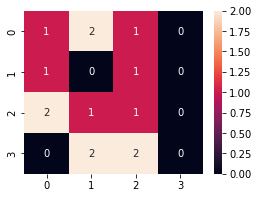

In [6]:
S = np.zeros(16)  # save the state values in a matrix
Pie = np.zeros(16)  # action_space in a policy matrix
g.reset()

def get_argmax_pa(current_state):
    # a = argmax(r + gV(s')|s',r)
    action_space = g.P[current_state]  # scan for all the actions
    tmp = np.zeros(4)
    for j, (action, x) in enumerate(action_space.items()):  # argmax(p(a|s) * p(s',r|s,a) * [r+gV(s')])
        (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
        tmp[action] = reward + gamma * S[next_state]
    return np.argmax(tmp)  # r + gV(s')

def policy_improvement():  # -------------------------------------------------- 3.Policy Improvement
    max_iter = 10  # prevent from a dead loop
    for i in range(max_iter):
        policy_stable = True  # -----------------------------------------------    policy-stable <- true
        for current_state in range(g.observation_space.n):  # -----------------    for each s belongs to S:
            old_action_policy = Pie[current_state]  # -------------------------       old-action <- pie(s)
            Pie[current_state] = get_argmax_pa(current_state)  # --------------       pie(s) <- argmax(sigma(p(s',r|s,a) * [r+gV(s')]))
            if old_action_policy != Pie[current_state]:  # --------------------       if old-action != pie(s), then
                policy_stable = False  # --------------------------------------          policy-stable <- false
        if policy_stable:  # --------------------------------------------------    if policy-stable, then
            print('policy stable')
            break  # ----------------------------------------------------------       return V = v*
        else:  # --------------------------------------------------------------    else:
            print('policy improving')
            policy_iter()  # --------------------------------------------------       go to 2 (improve it)
    pass

policy_improvement()
arr = Pie.reshape(-1, 4)
df = pd.DataFrame(arr)  # turn 2-d array to dataframe
fig, ax = plt.subplots(figsize=(4, 3))  # figure size
sns.heatmap(df, annot=True)  # display both color and value


# 2. Got an Optimized Policy by Value_Iteration

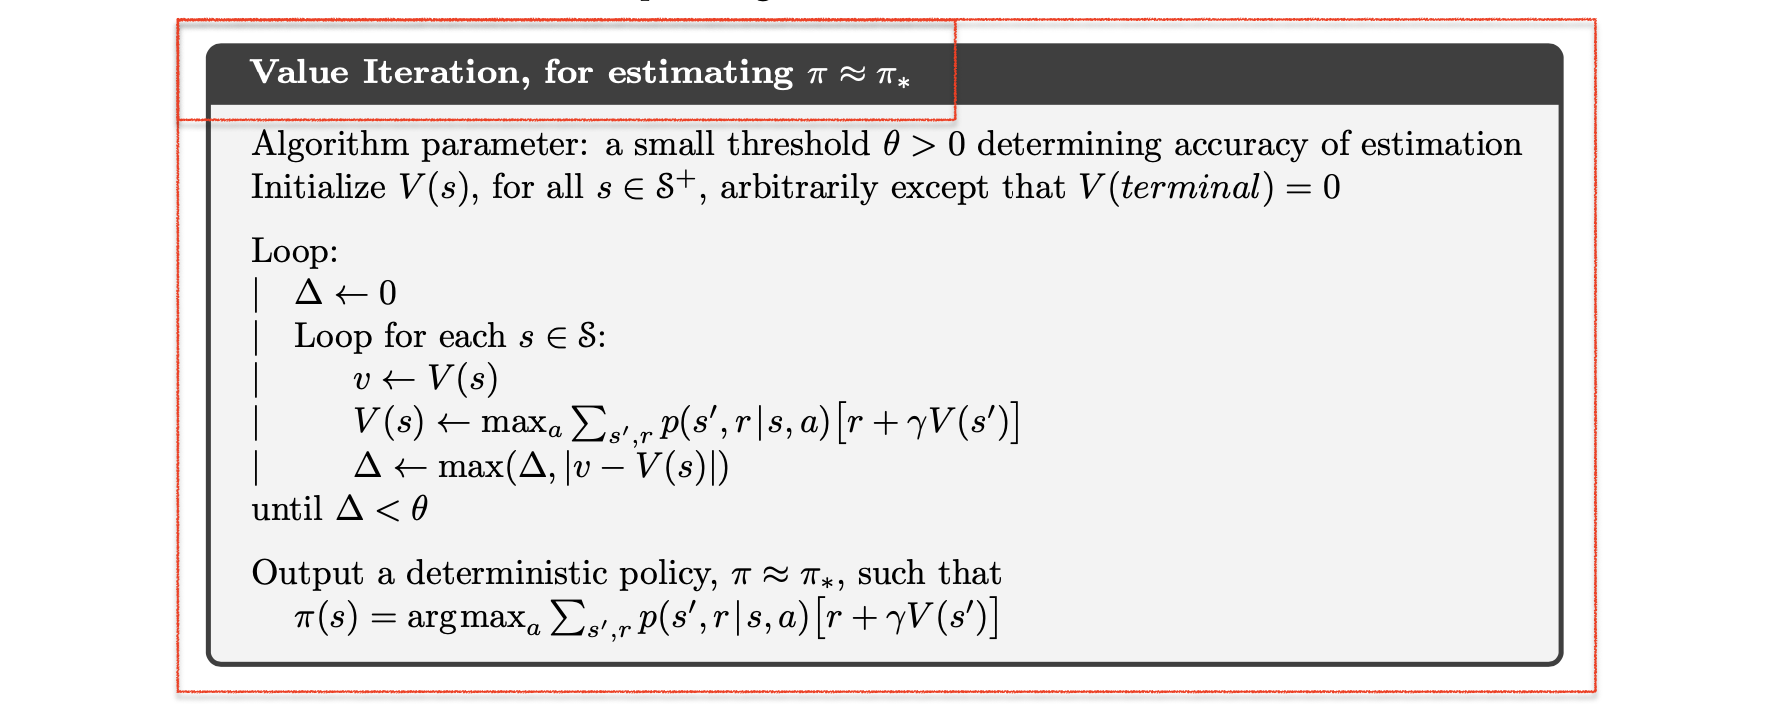

iter=0, continue
iter=1, continue
iter=2, continue
iter=3, continue
iter=4, continue
iter=5, continue
iter=6, converge at i=6, delta=0.000000



<AxesSubplot:>

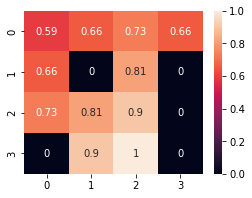

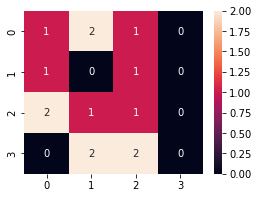

In [7]:
theta = 0.01  # error threshold
gamma = 0.9  # discord factor
S = np.zeros(16)  # save the state values in a matrix
Pie = np.zeros(16)  # action_space in a policy matrix
g.reset()

def get_max_vs(current_state):
    action_space = g.P[current_state]  # scan for all the actions
    tmp = np.zeros(4)
    for j, (action, x) in enumerate(action_space.items()):  # argmax(p(a|s) * p(s',r|s,a) * [r+gV(s')])
        (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
        tmp[action] = reward + gamma * S[next_state]
    vs2 = max(tmp)  # V(s) <-- max(a)
    return vs2

def value_iter():
    max_iter = 20  # prevent from a dead loop
    for i in range(max_iter):  # -------------------------------------------   loop:   
        print('iter=%d, ' % i, end='')
        delta = 0  # delta init  # -----------------------------------------      delta <= 0
        for current_state in range(g.observation_space.n):  # --------------      for each s belongs to S:
            vs1 = S[current_state]  # v <- V(s)  # -------------------------         v <- V(s)
            vs2 = get_max_vs(current_state)  # -----------------------------         V(s) <- max(sigma(p(s',r|s,a) * [r+gV(s')]))
            delta = max(np.fabs(vs1 - vs2), delta)  # ----------------------         delta <- max(delta, abs(vs1-vs2))
            S[current_state] = vs2  # update state value
        if(delta < theta):  # ----------------------------------------------   until delta < theta
            print('converge at i=%d, delta=%f\n' % (i, delta))
            break 
        else:
            print('continue')

    for current_state in range(g.observation_space.n):  # ------------------   output a deterministic policy pie*, such that
        Pie[current_state] = get_argmax_pa(current_state)  # ---------------      pie(s) = argmax(sigma(p(s',r|s,a) * [r+gV(s')]))
    pass


value_iter()
arr = S.reshape(-1, 4)
df = pd.DataFrame(arr)  # turn 2-d array to dataframe
fig, ax = plt.subplots(figsize=(4, 3))  # figure size
sns.heatmap(df, annot=True)  # display both color and value

arr = Pie.reshape(-1, 4)
df = pd.DataFrame(arr)  # turn 2-d array to dataframe
fig, ax = plt.subplots(figsize=(4, 3))  # figure size
sns.heatmap(df, annot=True)  # display both color and value

# Agent plays with value iteration

In [8]:
import numpy as np
import gymnasium as gym
import time
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


class Foo:
    def __init__(self):
        self.g = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="human")
        self.g.reset()
        self.theta = 0.01  # error threshold
        self.gamma = 0.9  # discord factor
        self.S = np.zeros(16)  # save the state values in a matrix
        self.Pie = np.zeros(16)  # action_space in a policy matrix
        pass

    def get_accum(self, current_state):
        action_space = self.g.P[current_state]  # scan for all the actions
        vs2 = 0
        for j, (action, x) in enumerate(action_space.items()):  # accumulation(p(a|s) * p(s',r|s,a) * [r+gV(s')])
            p = 1 / len(action_space)  # P(a|s)
            (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
            vs2 += p * 1 * (reward + self.gamma * self.S[next_state])  # P(a|s) * p(s',r|s,a) * [r+gV(s')]
            # print('p(s\'=%d|s=%d,a=%d) = %.1f, vs2=%.2f' % (next_state, current_state, action, prob['prob'], vs2))
        return vs2

    def policy_iter(self):  # implementation of Iterative Policy Evaluation, for estimating V = v(pie)
        max_iter = 100  # prevent from a dead loop
        for i in range(max_iter):  # ---------------------------------------------   Loop:
            print('iter=%d, ' % i, end='')
            delta = 0  # current error -------------------------------------------      delta <- 0
            for current_state in range(self.g.observation_space.n):  # -----------      loop for each s belongs to S
                vs1 = self.S[current_state]  # -----------------------------------         v <- V(s)
                vs2 = self.get_accum(current_state)  # ---------------------------         V(s) <- sigma(p(a|s) * p(s',r|s,a) * [r+gV(s')])
                delta = max(np.fabs(vs1 - vs2), delta)  # ------------------------      delta <- max(delta, abs(vs1-vs2))
                self.S[current_state] = vs2  # update state value
            if delta < self.theta:  # --------------------------------------------   until delta < theta
                print('converge at i=%d, delta=%f\n' % (i, delta))
                break
            else:
                print('continue')
        pass

    def get_argmax_pa(self, current_state):
        # a = argmax(r + gV(s')|s',r)
        action_space = self.g.P[current_state]  # scan for all the actions
        tmp = np.zeros(4)
        for j, (action, x) in enumerate(action_space.items()):  # argmax(p(a|s) * p(s',r|s,a) * [r+gV(s')])
            (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
            tmp[action] = reward + self.gamma * self.S[next_state]
        return np.argmax(tmp)  # r + gV(s')

    def policy_improvement(self, visual=True):
        max_iter = 10  # prevent from a dead loop
        for i in range(max_iter):
            policy_stable = True
            for current_state in range(self.g.observation_space.n):  # -----------    for each s belongs to S:
                old_action_policy = self.Pie[current_state]  # -------------------       old-action <- pie(s)
                self.Pie[current_state] = self.get_argmax_pa(current_state)  # ---       pie(s) <- argmax(sigma(p(s',r|s,a) * [r+gV(s')]))
                if old_action_policy != self.Pie[current_state]:  # --------------       if old-action != pie(s), then
                    policy_stable = False  # -------------------------------------          policy-stable <- false
            if policy_stable:  # -------------------------------------------------    if policy-stable, then
                print('policy stable')
                break  # ---------------------------------------------------------       return V = v*
            else:  # -------------------------------------------------------------    else:
                print('policy improving')
                self.policy_iter()  # --------------------------------------------       go to 2 (improve it)
        if visual:
            self.post_processing()  # this is improved V and Pai
        pass
    
    def get_max_vs(self, current_state):
        action_space = self.g.P[current_state]  # scan for all the actions
        tmp = np.zeros(4)
        for j, (action, x) in enumerate(action_space.items()):  # argmax(p(a|s) * p(s',r|s,a) * [r+gV(s')])
            (trans_prob, next_state, reward, is_terminal_state) = x[0]  # extract variables
            tmp[action] = reward + self.gamma * self.S[next_state]
        return max(tmp)  # V(s) <-- max(a)

    def value_iter(self, visual=True):
        max_iter = 20  # prevent from a dead loop
        for i in range(max_iter):  # ---------------------------------------------   loop:
            print('iter=%d, ' % i, end='')
            delta = 0  # delta init  # -------------------------------------------      delta <= 0
            for current_state in range(self.g.observation_space.n):  # -----------      for each s belongs to S:
                vs1 = self.S[current_state]  # v <- V(s)  # ----------------------         v <- V(s)
                vs2 = self.get_max_vs(current_state)  # --------------------------         V(s) <- max(sigma(p(s',r|s,a) * [r+gV(s')]))
                delta = max(np.fabs(vs1 - vs2), delta)  # ------------------------         delta <- max(delta, abs(vs1-vs2))
                self.S[current_state] = vs2  # update state value
            if delta < self.theta:  # --------------------------------------------   until delta < theta
                print('converge at i=%d, delta=%f\n' % (i, delta))
                break
            else:
                print('continue')
        for current_state in range(self.g.observation_space.n):  # ---------------   output a deterministic policy pie*, such that
            self.Pie[current_state] = self.get_argmax_pa(current_state)  # -------      pie(s) = argmax(sigma(p(s',r|s,a) * [r+gV(s')]))
        if visual:
            self.post_processing()  # this is improved V and Pai
        pass
    
    @staticmethod
    def __post_processing(arr):
        df = pd.DataFrame(arr.reshape(-1, 4))  # turn 2-d array to dataframe
        fig, ax = plt.subplots(figsize=(4, 3))  # figure size
        sns.heatmap(df, annot=True)  # display both color and value

    def post_processing(self):
        self.__post_processing(self.S)
        self.__post_processing(self.Pie)
        pass

    def play(self):
        self.g.reset()  # Resets the environment to an initial state, required before calling step. Returns the first agent observation for an episode and information, i.e. metrics, debug info.
        self.g.render()  # Renders the environments to help visualise what the agent see, examples modes are “human”, “rgb_array”, “ansi” for text.
        s = 0
        is_terminated = False
        while not is_terminated:
            a = int(self.Pie[s])
            if a == 0: print('left')
            elif a == 1: print('down')
            elif a == 2: print('right')
            elif a == 3: print('up')
            else: sys.exit(250)
            (s, reward, is_terminated, truncated, prob) = self.g.step(a)
            time.sleep(1)
        print('Congratulations, your agent successfully got the present. Game ends.')
        pass


for i in range(3):
    foo = Foo()
    print('#############################################################')
    print('## Training  Agent with policy_improvement ##################')
    print('#############################################################')
    foo.policy_improvement(visual=False)
    print('#############################################################')
    print('## Playing FrozenLake with trained policy ###################')
    print('#############################################################')
    foo.play()

    print('\n## Reset the game #########################################\n')

    foo = Foo()
    print('#############################################################')
    print('## Training  Agent with value_iteration #####################')
    print('#############################################################')
    foo.value_iter(visual=False)
    print('#############################################################')
    print('## Playing FrozenLake with trained policy ###################')
    print('#############################################################')
    foo.play()


#############################################################
## Training  Agent with policy_improvement ##################
#############################################################
policy improving
iter=0, continue
iter=1, continue
iter=2, continue
iter=3, continue
iter=4, converge at i=4, delta=0.009398

policy improving
iter=0, converge at i=0, delta=0.004558

policy stable
#############################################################
## Playing FrozenLake with trained policy ###################
#############################################################
down
down
right
down
right
right
Congratulations, your agent successfully got the present. Game ends.

## Reset the game #########################################

#############################################################
## Training  Agent with value_iteration #####################
#############################################################
iter=0, continue
iter=1, continue
iter=2, continue
iter=3, continue
iter=4, cont

# The optimized route will looks like:

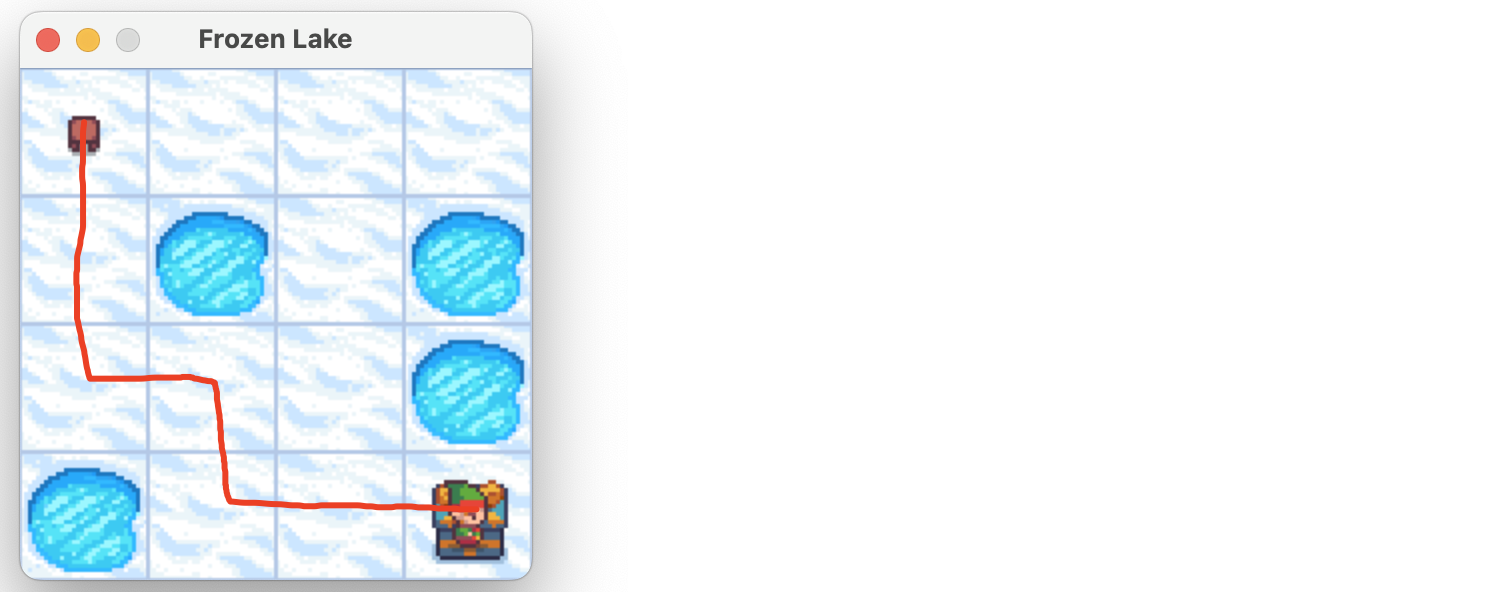